# 0 - Running *IDWT*

### *Ground Potential*

The following short tutorial focuses in the *Inverse Weighted Distance Transform or IWDT* which forms the basis of the **NetSim** package.

### imports

In [1]:
import geopandas as gpd
import numpy as np
import netsim.utils as utils
import netsim.path_tools as ptools
from netsim.cost import calculate_dt, calculate_iwdt

### Reading files

#### *Read DEM*

In [2]:
fn = r'..\data\sample\sampleDEM.tif'

In [3]:
dem, profile = utils.read_raster(fn)

In [4]:
#find the cellsize of the dem
cellsize = profile['transform'].a

#### *Read shapefile into a geopandas dataframe*

In [5]:
fn = r'..\data\sample\sample5.shp'

##### read and make a copy of original dataframe

In [6]:
df_temp = gpd.read_file(fn)

# make a copy
df = df_temp.copy(deep=True)
df

,id,seq,group,mix,easting,northing,geometry
0,0,1,1,0,530782,4389390,POINT (530782 4389390)
1,1,1,1,0,531119,4388860,POINT (531119 4388860)
2,2,1,1,0,530403,4388580,POINT (530403 4388580)
3,3,1,1,0,530503,4388620,POINT (530503 4388620)
4,4,1,1,0,530729,4388930,POINT (530729 4388930)
5,5,1,1,0,530606,4389150,POINT (530606 4389150)


### Preliminaries

##### *Convert point coordinates into rows and column and add to dataframe*

In [7]:
df['r'], df['c'] = utils.pt2rc(df['geometry'], profile)
df

,id,seq,group,mix,easting,northing,geometry,r,c
0,0,1,1,0,530782,4389390,POINT (530782 4389390),18,104
1,1,1,1,0,531119,4388860,POINT (531119 4388860),124,171
2,2,1,1,0,530403,4388580,POINT (530403 4388580),180,28
3,3,1,1,0,530503,4388620,POINT (530503 4388620),172,48
4,4,1,1,0,530729,4388930,POINT (530729 4388930),110,93
5,5,1,1,0,530606,4389150,POINT (530606 4389150),66,68


##### *Plot locations*

In [8]:
hillshade = utils.calculate_hillshade(dem)

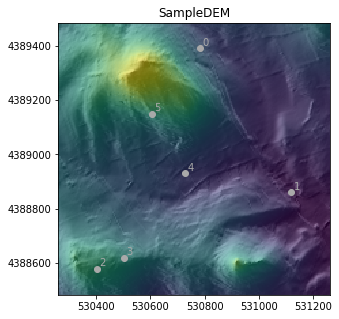

In [11]:
plot_map(raster= {'ras':dem, 'profile':profile, 'bground': hillshade},
               loc={'df':df, 'label': 'id'},
               title='SampleDEM')

##### *read gradient to cost coefficients*

The ``grad2cost.csv`` contains the relation between gradient (degrees) and metabolic cost.

In [12]:
# vertical factor table
vftfn = r'..\data\iwdt\grad2cost.csv'

##### *find coefficients for gradient (degrees) to cost function*

In [13]:
vft = np.genfromtxt(vftfn, delimiter=',')

##### *fit a 4<sup>th</sup> degree polynomial to metabolic cost*

First we will transform the degrees into radians and then we calculated the tangent.

In [14]:
coef = np.polyfit(np.tan(np.radians(vft[: , 0])), vft[:,1], deg=4)
coef

array([ 14.58472386, -20.89105302,  41.30992529,  16.89952776,
         2.57058679])

### Creating a path

Next, we shall generate a simple path from point 0 to 2. To do this, we first initialize our *IDWT* raster (a 2D numpy array with the same dimensions as *DEM*) so that the cell value that corresponds to the location of point 0 is set to 0.0 and the rest of the cell values are initialized to some very large number e.g. 99999.0

##### *initializing a numpy 2D array to 99999.0*

In [15]:
iwdt = np.full_like(dem, 999999.0)

##### *set the cell value for point 0 to 0.0*

In [16]:
# retrieve the row and column of point 0
sel = df['id'] == 0
row_0 = df.loc[sel, 'r'].values[0]
col_0 = df.loc[sel, 'c'].values[0]

# set to 0.9
iwdt[row_0, col_0]= 0.0

##### generate the *iwdt* dictionary, `iwdt_dict()`

To run the `calculate_iwdt()` we need to generate a dictionary with the following entries:

- 'dem': digital elevation model
- 'netcost': existing netcost (if such exists)
- 'cellsize': cell resolution of the *dem*
- 'weight': weight (0.0-1.0) we want to give to the prexisting *netcost*
- 'coef': coefficients of the polynomial we use to calculate costs based on the slope as derived from 
  the *dem*

In [17]:
cost_dict={
    'dem': dem,
    'netcost': np.zeros_like(dem), # no previous netcost
    'cellsize': cellsize,
    'weight': 0.0,                 # it does not matter what we put here as netcost is made out of 0s
    'coef': coef
}

##### run `iwdt()`

In [18]:
iwdt, blx, bly = calculate_iwdt(iwdt, cost_dict)

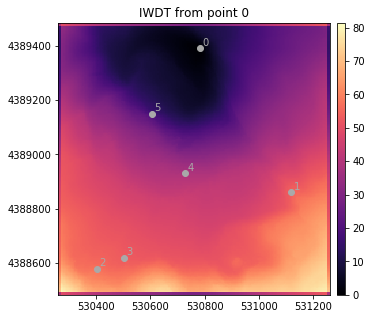

In [19]:
plot_map(raster = {'ras':iwdt, 'profile':profile},
               loc={'df':df, 'label':'id'},
               cmap='magma',
               title= 'IWDT from point 0',
               cbar = True)

##### *find path connecting 0 to 2*

In [20]:
# retrieve the row and column of point 2
sel = df['id'] == 2
row_2 = df.loc[sel, 'r'].values[0]
col_2 = df.loc[sel, 'c'].values[0]

In [21]:
origin = [row_0, col_0]
dest = [row_2, col_2]
path0_2, _ = ptools.create_paths(blx, bly, [origin], [dest])

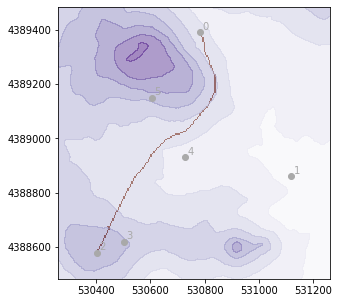

In [22]:
plot_map(raster= {'ras':dem, 'profile':profile, 'paths': path0_2},
               loc={'df':df, 'label':'id'},
               cmap='Purples')

## Exploring path influence

While `calculate_iwdt()` can generate similar paths as generated by other GIS, the true advantage of using `calculate_iwdt()` is the possibility of incorporating an *influence weighted* layer that we can use when calculating additional paths. You should think of this *influence weighted* layer as the inverse of a cost layer. The higher the influence the less the cost and vice versa. In this particular case, we are going to generate our *influence (cost) weighted* layer from the path we just generated so that its influence is maximum (i.e. cost is minimum) while on the path and declines (or increases for the cost) exponentially with distance. 

##### *generating influence layer*

Here, we shall consider that at a distance of $d$= 0m the cost of the path is minimum while at a distance of $d$=25m its cost has exponentially increased to $\frac{1}{4} $. To do this we use the following formulae,

 $$ PathCost= 1 - e^{d/\alpha} $$

Where,
- $d$ distance from path
- $\alpha$ is a factor calculated using the following formula,
$$ \alpha = \frac {d_0} {ln(1 - NC_0)} $$   

In order to calculate such a layer, we first need to generate a layer that calculates distance away from the path. We do this using the `calculate_dt()` function.

##### *initialize a layer to 99999.0 and set path location to 0.0*

In [23]:
d = np.full_like(dem, 99999.0)
d[path0_2 >= 1.0] = 0.0

##### *calculate distance away*

In [24]:
d = calculate_dt(d, cost_dict['cellsize'], option=2)

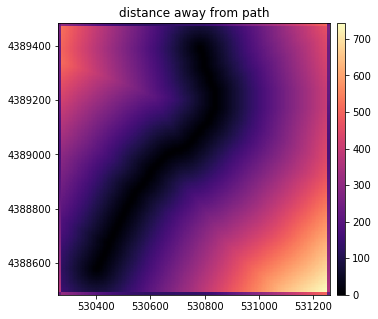

In [25]:
utils.plot_map(raster= {'ras':d, 'profile':profile},
               cmap='magma',
               title= 'distance away from path',
               cbar= True)

##### *calculate the influence (cost) associated with the path*

In [26]:
from math import log

d0 = 25 # distance @ which 
NC0 = 0.25  # cost is only beta
alpha = d0 / log(1- NC0)

# path influence layer
pathcost = 1.0 - np.exp(d / alpha)

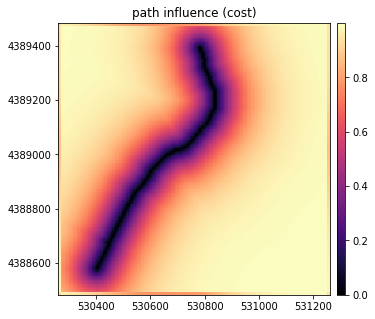

In [27]:
utils.plot_map(raster= {'ras':pathcost, 'profile':profile},
               cmap='magma',
               title= 'path influence (cost)',
               cbar = True)

### Generate a second path with varying weight

Now that we have generated a layer that describes the influence of the path from 0 to 2, we are going to generate a second path from 1 to 2. For this however, we are going to be varying the weight associated with our first path.

##### *calculate path connecting 1 to 2*

In [28]:
# retrieve the row and column of point 1
sel = df['id'] == 1
row_1 = df.loc[sel, 'r'].values[0]
col_1 = df.loc[sel, 'c'].values[0]

# new origin
origin = [row_1, col_1]

#### Loop through weights

In [29]:
ws = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

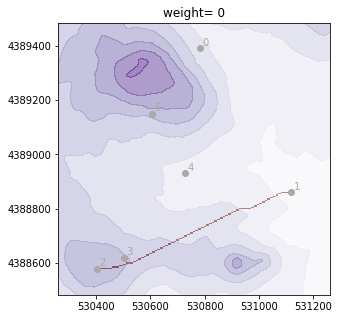

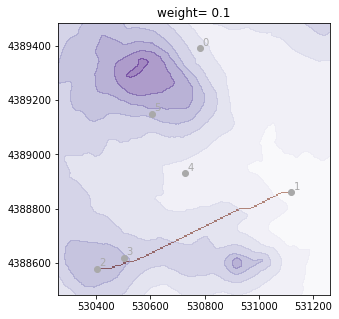

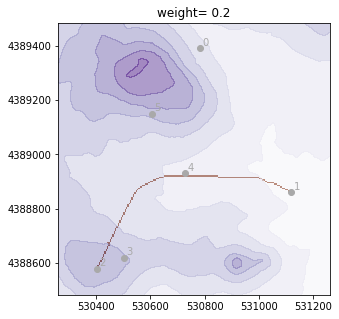

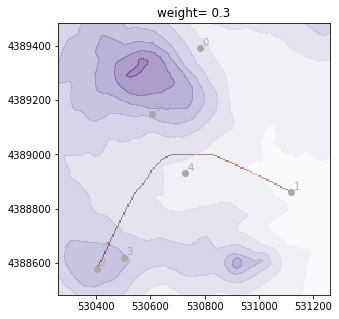

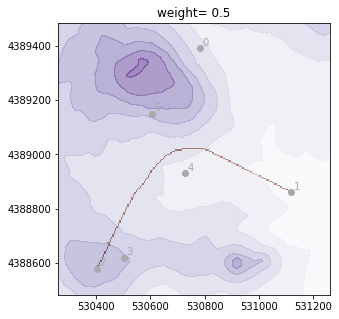

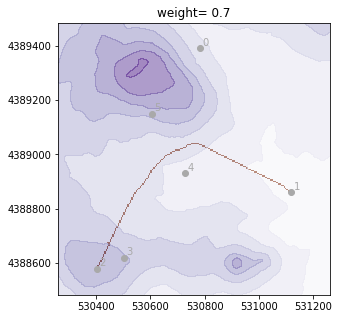

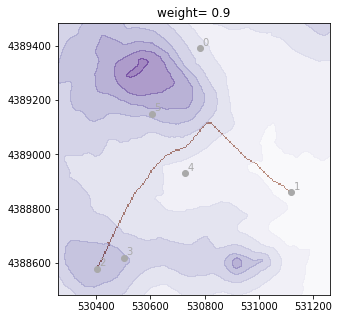

In [30]:
# set netcost
cost_dict['netcost'] = pathcost

for w in ws:
    # Change weight
    cost_dict['weight'] = w
    
    # initialize iwdt
    iwdt = np.full_like(dem, 999999.0)
    iwdt[origin[0], origin[1]] = 0.0
    
    # run iwdt
    iwdt, blx, bly = calculate_iwdt(iwdt, cost_dict)
    
    # find path
    path, _ = ptools.create_paths(blx, bly, [origin], [dest])
    
    # printout results
    plot_map({'ras':dem, 'profile':profile, 'paths':path},
                   loc={'df':df, 'label':'id'}, 
                   cmap='Purples',
                   title= 'weight= '+ str(w) )

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_map(raster, loc= None, title= None, figsize= (5,5), cmap= 'viridis', cbar= False, save= None, **kwother):
    '''
    Basic raster plot.
    
    Parameters
    ----------
    
    raster: dictionary
        dictionary must have at least two entries:
        
        - **'ras'**: 2D numpy array representing a raster
        - **'profile': raster information (as derived from *rasterio*)
        - *Optional* entries are:
          
          - *'bground'*: a 2D numpy array representing a background raster. Typically a hillshade.
          - *'paths'*:  dataframe representing a network of paths as obtained from ``calculate_paths()`` 
    
    loc: dictionary or geodataframe, optional 
        used to identify point locations. if *dictionary* then it must have at least two entries:
        
        - **'df'**:  geopandas framework holding point data.
        - **'label'**: name of the column in 'df' used to label points.
    
    title: string, optional
        if not empty then title to be used when displaying ras
    
    figsize: tuple
        Size of figure. *Default*: (5,5)
    
    cmap: string
        name of the matplotlib colormap. *Default:* 'viridis'
    
    cbar: boolean
        if True colorbar is displayed. *Default:* False
    
    save: string, optional
        if not empty then name of the output image. *Default: None*
        
        
    '''
   
    # set colormap
    if cmap:
       cmap = mpl.cm.get_cmap(cmap)
    
    if cbar: # colorbar?       
        wcbar = 0.03
        gridspec_kw={'width_ratios':[1,wcbar], 'wspace': 0.05}
        fig, (ax, cax) = plt.subplots(ncols = 2, figsize= (figsize[1] + figsize[1]*wcbar, figsize[0]), gridspec_kw=gridspec_kw)
    else:
        fig, ax = plt.subplots(ncols = 1, figsize= figsize)

    # raster
    if isinstance(raster, dict):
        if set(['ras', 'profile']) <= set(raster.keys()):
            
            # default
            img = raster['ras']
            profile = raster['profile']
            alpha = 1.0

            # calculate extension
            bounds = raster['profile']['bounds']
            extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
            
            # background image?
            if 'bground' in raster.keys():
                alpha = 0.5
                im0 = ax.imshow(raster['bground'], extent= extent, origin='upper', cmap= mpl.cm.get_cmap('Greys'),**kwother)

            # nodata?
            if np.any(img == profile['nodata']):
                nodata_mask = img == profile['nodata']
                img = np.ma.array(img, mask = nodata_mask)
                cmap.set_bad('white',0.0)
                
            # paths overlay?    
            if 'paths' in raster.keys():
                
                # assuming img is a dem
                cmap.set_bad('white',0.0)
                ax.contourf(img, 6, extent=extent, origin= 'upper', cmap= cmap, alpha=0.5)
                
                # path_mask = no paths
                paths_mask = raster['paths'] == 0.0

                # combine with existing mask?
                if np.ma.is_masked(img):
                    combined_mask = nodata_mask * paths_mask
                else:
                    combined_mask = paths_mask
                
                # apply mask to path 
                img_paths = np.ma.array(raster['paths'], mask= combined_mask)
                
                # plot paths
                cmap_path = mpl.cm.get_cmap('Oranges_r')
                cmap_path.set_bad('white',0.0)
                im1 = ax.imshow(img_paths, origin= 'upper', cmap= cmap_path, extent= extent, alpha= alpha, **kwother)
                
            else: # regular plot
                im1 = ax.imshow(img, origin= 'upper', cmap= cmap, extent= extent, alpha= alpha, **kwother)
            
            # colorbar?
            if cbar:
                fig.colorbar(im1, cax= cax)
        else:
            raise Exception('raster is missing  ''"ras"'' and/or ''"profile"'' keys! ')
    else:
        raise Exception('raster must be a dictionary')

    
    if title:
        ax.set_title(title)
        
    # locations?
    if not loc is None:
        # is it a dictionary?
        if isinstance(loc, dict):
            if set(['df', 'label']) <= set(loc.keys()):
                xs, ys = loc['df']['geometry'].x.values, loc['df']['geometry'].y.values
                labels = loc['df'][loc['label']].values
                data = zip(labels, xs, ys )  
                ax.scatter(xs,ys, color='darkgray')        
                for id, x, y in data:
                    ax.annotate(str(id), xy=(x,y), color='darkgray', xytext= (2.5,2.5), textcoords='offset points')                
            else:
                 raise Exception('Loc does not have the right keys!')
        else:
             if isinstance(loc, gpd.geodataframe.GeoDataFrame):
                    xs, ys = loc['geometry'].x.values, loc['geometry'].y.values
                    data = zip(xs, ys)
                    ax.scatter(xs,ys, color='darkgray')        
             else:
                raise Exception('Not a dictionary or dataframe!!')

    # saving output?
    if save:
        output= save+'.png'      
        plt.savefig(fname= output, dpi= 300)

    plt.show()